# Exploratory Data Analysis

In this notebook, we conduct exploratory data analysis to investigate the nature of the textual features and discover potential relationships between the features and the target variable that could aid in the prediction of ratings.  

In [1]:
# General Imports
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from os.path import join

# EDA related imports
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
# Load the downsampled preprocessed data
data_dir = "data/"
data = pd.read_csv(join(data_dir, "downsampled_preprocessed_train_50000.csv"))[["Rating", "ReviewFull"]]
data["ReviewFull"] = data["ReviewFull"].apply(str)
display(data)

,Rating,ReviewFull
0,1,diappointed service order thing direct address...
1,1,allsop scratch repair kit product according pa...
2,1,angry requirements years old ibook running tig...
3,1,yawn years heard film scary disturbing long ag...
4,1,terrible waste time bother switches past prese...
...,...,...
49995,5,loved book finished reading flying seat pants ...
49996,5,beautiful marriage photographs text photograph...
49997,5,great came soon days functions compared compet...
49998,5,perfectly written novel think safe read book g...


### Sentiment Polarity - Rating Analysis

First we attempt to find whether or not any relationship exists between the sentiment polarity of a review and the rating. We do so by observing how to average sentiment of reviews changes with rating 

In [3]:
# Define function to extract a string's sentiment
find_sentiment = lambda text: TextBlob(text).sentiment.polarity

# Create new column in dataframe
data["sentiment"] = data["ReviewFull"].apply(find_sentiment)

In [4]:
data

,Rating,ReviewFull,sentiment
0,1,diappointed service order thing direct address...,0.100000
1,1,allsop scratch repair kit product according pa...,-0.383333
2,1,angry requirements years old ibook running tig...,-0.229167
3,1,yawn years heard film scary disturbing long ag...,-0.120238
4,1,terrible waste time bother switches past prese...,-0.450000
...,...,...,...
49995,5,loved book finished reading flying seat pants ...,0.438889
49996,5,beautiful marriage photographs text photograph...,0.329972
49997,5,great came soon days functions compared compet...,0.750000
49998,5,perfectly written novel think safe read book g...,0.217898


Mean Sentiment for Rating 1: -0.020977252429221847
Mean Sentiment for Rating 2: 0.076262319188291
Mean Sentiment for Rating 3: 0.17603973772561016
Mean Sentiment for Rating 4: 0.2672978042926097
Mean Sentiment for Rating 5: 0.3349858326232592


<AxesSubplot:xlabel='Rating'>

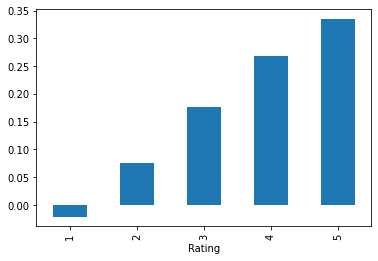

In [5]:
# Plot mean sentiment against rating 
for rating in range(1,6):
    print(f"Mean Sentiment for Rating {rating}: {data[data['Rating'] == rating]['sentiment'].mean()}")

data.groupby("Rating")["sentiment"].mean().plot(kind="bar")

From this, we can see that there is a positive correlation between the mean sentiment of the reviews and the rating it recieved. We can get further insight into this relationship using a scatter plot visualization 

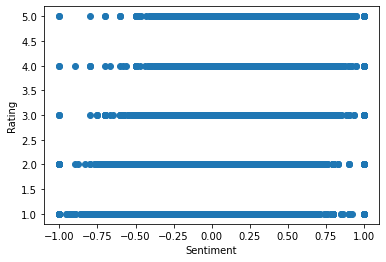

In [7]:
plt.scatter(data["sentiment"], data["Rating"])
plt.xlabel("Sentiment")
plt.ylabel("Rating")
plt.show()

As we can see from the above plot, though we see a positive correlation with the mean sentiment of the reviews, when looking at the data at an individual level, we see that there is a lot of variance and overlap between the sentiment values of reviews of different ratings. We can investigate further by seeing what the most common words that contirbute to this sentiment are.   

In [8]:
# Function for finding n nost common words in a series
num_most_common = 25
find_n_most_common = lambda text, n: Counter(' '.join(text).split()).most_common(n)
most_common = data.groupby("Rating")["ReviewFull"].apply(lambda x: find_n_most_common(x, num_most_common))

for rating in range(1,6):
    idx = rating - 1
    print(f"Most Common Words for Rating {rating} sorted by sentiment: ")   
    # Display the most common words in each rating sorted by sentiment 
    print(list(sorted(most_common.iloc[idx], key=lambda x: TextBlob(x[0]).sentiment.polarity)))
    print("\n")

    


Most Common Words for Rating 1 sorted by sentiment: 
[('bad', 1540), ('waste', 1315), ('book', 5092), ('like', 2740), ('time', 2145), ('money', 1927), ('movie', 1922), ('product', 1885), ('buy', 1851), ('read', 1617), ('work', 1379), ('bought', 1284), ('use', 1201), ('got', 1035), ('way', 976), ('know', 947), ('amazon', 926), ('people', 913), ('want', 908), ('think', 879), ('dvd', 868), ('new', 966), ('better', 1154), ('good', 2040), ('great', 1096)]


Most Common Words for Rating 2 sorted by sentiment: 
[('disappointed', 962), ('bad', 1044), ('little', 1089), ('book', 5860), ('like', 3394), ('time', 1930), ('movie', 1805), ('read', 1777), ('use', 1290), ('work', 1248), ('bought', 1188), ('story', 1173), ('way', 1138), ('product', 1129), ('buy', 1070), ('think', 988), ('got', 976), ('quality', 960), ('know', 896), ('album', 892), ('want', 885), ('new', 994), ('better', 1761), ('good', 3244), ('great', 1862)]


Most Common Words for Rating 3 sorted by sentiment: 
[('bad', 1052), ('littl

From the above cell, we see the lower rating reviews have many occurences of negative words such as "bad", "waste", and "terrible" whereas higher rating reviews have many occurences of positive words such as "best" and "excellent". However, we see that there are some words of the same sentiment that occur numerous times in reviews from all the ratings, like "better" and "good". 

When finding the sentiment of a sentence using TextBlob as done above, the sentiment is calculated by a simple averaging of the sentiments of the individual words of the sentence. However, this approach does not accurately represent the differences in sentiment of two senetences that use similar words but in different contexts. 

For instance, the sentence "the movie was better than most other" and the sentence "the movie could have been much better" both use similar words such as "better" but have completely different sentiments. 

This dicovery shows us that when conducting sentiment analysis and attempting to predict ratings, we must use a encoding of the review which captures its contextual meaning.

### Topic Modeling

We now will attempt to use an unsupervised topic modeling approach using non-negative matrix factorization to try and categorize reviews into 5 groups based on their content and try to see whether or not the general topics of the reviews are in any way correlated with their corresponding ratings. 

In [9]:
def display_topics(model, words, num_top_words):
    """Function to display the top num_top_words topic words given an NMF model and word vocabulary"""
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([words[i]
                          for i in topic.argsort()[:-num_top_words - 1:-1]]))


The train dataset we use for the NMF model will be the TF-IDF vectors of each individual review in the dataset. We restrict the max features (vocabulary size) computed by the TF-IDF vectorizer in order to reduce redundancy and for performance reasons.

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(data["ReviewFull"])

# Create document term matrix showing the TF-IDF score for each word in each review
tfidf_words = tfidf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_words))
doc_term_matrix

,abilities,ability,able,abs,absence,absolute,absolutely,absorbed,absurd,abuse,...,youtube,yrs,yuck,zen,zero,zipper,zombie,zombies,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Fit the NMF model and generate top 5 topics
num_top_words = 10
num_topics = 5
nmf = NMF(n_components=num_topics, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_words, num_top_words)

Topic 0:
product great good use work price time bought quality buy
Topic 1:
book read books story reading good author written like characters
Topic 2:
movie film watch movies story good dvd bad like seen
Topic 3:
album songs music like song best good love band great
Topic 4:
game fun play games graphics like played playing old buy


/home/vinay/anaconda3/envs/askoski/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


From the above cell, we can infer from Topic 0 that all reviews corresponding to it are related to postive reviews with high ratings. However, for the rest of the topics, we see that the topic words are more closely related to the content of the reviews rather than its overall rating or positivity/negativity. As our task is sentiment analysis and not topic categorization, this modeling does not prove to be of much use.

In [12]:
num_top_words = 10
num_topics = 10
nmf = NMF(n_components=num_topics, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_words, num_top_words)

Topic 0:
use time like work bought money buy little got works
Topic 1:
book information author reading written read pages recommend books understand
Topic 2:
movie watch film movies seen acting bad funny watching like
Topic 3:
album songs music song like best band listen rock love
Topic 4:
game play fun games graphics played playing like gameplay buy
Topic 5:
good pretty price bad quality overall better little think sound
Topic 6:
great love price works easy loved wonderful loves perfect recommend
Topic 7:
read story books characters series love reading novel like interesting
Topic 8:
dvd quality film version video player season sound series disc
Topic 9:
product amazon received price item ordered recommend quality purchased shipping
